# Prediction of Yield Losses due to Air Pollutants.

## Data Dictionary

|Feature|Definition|Data Type|
|-|-|-|
|**Date**|Period of Year|String|
|**District**|District|String|
|**SO2**|Sulpher Dioxide Content|Float|
|**NO2**|Nitrogen Dioxide Content|Float|
|**RSPM**|Respirable Suspended Particulate Matter|Float|
|**SPM**|Suspended Particulate Matter|Float|
|**AQI**|Air Quality Index|Float|
|**Rice Area**|Surface Area Rice is Cultivated|Integer|
|**Rice Production**|Total Rice Production For The Period|Integer|
|**Rice Yield**|Rice Production Per Area|Float|
|**Wheat Area**|Surface Area Wheat is Cultivated|Integer|
|**Wheat Production**|Total Wheat Production For The Period|Integer|
|**Wheat Yield**|Wheat Production Per Area|Float|

## Project Imports

In [67]:
import pandas as pd
from pandas import Series, DataFrame
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing, neighbors, metrics
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import (
    KFold, train_test_split, validation_curve,
    learning_curve, ShuffleSplit, cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_squared_error, r2_score, explained_variance_score, mean_absolute_error,
)
import warnings
warnings.filterwarnings('ignore')

## ETL

The first thing we need to do before starting any EDA is to load the data. We will get the data from all the CSV files and will load the data into a `pandas` dataframe.

Once loaded into a `DataFrame`, we will familiarize ourselves with the columns present, and their data types. Standard Python "snake_casing" is used to provide a DataFrame with field accessors most akin to Standard Python.

Let us profile the data by reading each file individually. 

In [2]:
dataDir = r'C:\Users\IAN\Desktop\demo pics\Ian\Ian'
os.chdir(dataDir)
dtype = {
    'date': 'str',
    'district': 'str',
    'so2': 'float64',
    'no2': 'float64',
    'rspm': 'float64',
    'spm': 'float64',
    'aqi': 'float64',
    'rice_area': 'int64',
    'rice_production': 'int64',
    'rice_yield': 'float64',
    'wheat_area': 'int64',
    'wheat_production': 'int64',
    'wheat_yield': 'float64'
}
colNames = list(dtype.keys())

In [3]:
ahmedabadYield = pd.read_csv('Ahmedabad.csv',skiprows=1,header=None, names=colNames)
ahmedabadYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              14 non-null     object 
 1   district          14 non-null     object 
 2   so2               14 non-null     float64
 3   no2               14 non-null     float64
 4   rspm              14 non-null     float64
 5   spm               14 non-null     float64
 6   aqi               14 non-null     float64
 7   rice_area         14 non-null     object 
 8   rice_production   14 non-null     object 
 9   rice_yield        14 non-null     float64
 10  wheat_area        14 non-null     int64  
 11  wheat_production  14 non-null     int64  
 12  wheat_yield       14 non-null     float64
dtypes: float64(7), int64(2), object(4)
memory usage: 1.5+ KB


All the attributes/columns are of the right datatype, except `rice_area` and `rice_production`.   Inspecting the records closely we see some data quality issues.  For some records there are thousand seperators and for most there are none.  Because of this mixed nature, pandas has marked the datatype as `object` instead of `int64`.  Let us remove the `comma` and set the datatype as int64.  

### Before

In [4]:
ahmedabadYield

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
0,1998-99,AHMEDABAD,7.850000,17.208333,104.200455,235.000000,235.000000,52200,72600,1.390805,91600,138900,1.516376
1,1999-00,AHMEDABAD,6.925000,16.608333,104.200455,300.000000,300.000000,75100,78900,1.050599,84000,114800,1.366667
2,2000-01,AHMEDABAD,10.175000,32.300000,104.200455,335.750000,335.750000,84100,37500,0.445898,48700,78500,1.611910
3,2001-02,AHMEDABAD,13.466667,33.408333,104.200455,261.750000,261.750000,82000,144300,1.759756,81000,103500,1.277778
4,2002-03,AHMEDABAD,16.187982,28.496361,104.200455,233.611749,233.611749,47500,39300,0.827368,79500,107400,1.350943
5,2003-04,AHMEDABAD,16.520577,24.882115,160.983798,255.275577,255.275577,83200,197600,2.375000,111400,182600,1.639138
6,2004-05,AHMEDABAD,13.179457,25.694186,119.527132,280.236434,280.236434,79000,176200,2.230380,124300,218000,1.753821
7,2005-06,AHMEDABAD,10.566810,22.313793,97.433476,216.858369,216.858369,95800,238400,2.488518,108000,191900,1.776852
8,2006-07,AHMEDABAD,14.164626,25.279252,110.525424,255.627119,255.627119,"100,100","186,900",1.867133,132400,228900,1.728852
9,2007-08,AHMEDABAD,12.544611,20.498204,96.382090,244.176119,244.176119,"108,000","222,700",2.062037,150200,275600,1.834887


In [5]:
ahmedabadYield['rice_area']=ahmedabadYield['rice_area'].str.replace(',','')
ahmedabadYield['rice_production']=ahmedabadYield['rice_production'].str.replace(',','')
ahmedabadYield['rice_area'] = ahmedabadYield['rice_area'].astype('int64')
ahmedabadYield['rice_production'] = ahmedabadYield['rice_production'].astype('int64')
ahmedabadYield

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
0,1998-99,AHMEDABAD,7.850000,17.208333,104.200455,235.000000,235.000000,52200,72600,1.390805,91600,138900,1.516376
1,1999-00,AHMEDABAD,6.925000,16.608333,104.200455,300.000000,300.000000,75100,78900,1.050599,84000,114800,1.366667
2,2000-01,AHMEDABAD,10.175000,32.300000,104.200455,335.750000,335.750000,84100,37500,0.445898,48700,78500,1.611910
3,2001-02,AHMEDABAD,13.466667,33.408333,104.200455,261.750000,261.750000,82000,144300,1.759756,81000,103500,1.277778
4,2002-03,AHMEDABAD,16.187982,28.496361,104.200455,233.611749,233.611749,47500,39300,0.827368,79500,107400,1.350943
5,2003-04,AHMEDABAD,16.520577,24.882115,160.983798,255.275577,255.275577,83200,197600,2.375000,111400,182600,1.639138
6,2004-05,AHMEDABAD,13.179457,25.694186,119.527132,280.236434,280.236434,79000,176200,2.230380,124300,218000,1.753821
7,2005-06,AHMEDABAD,10.566810,22.313793,97.433476,216.858369,216.858369,95800,238400,2.488518,108000,191900,1.776852
8,2006-07,AHMEDABAD,14.164626,25.279252,110.525424,255.627119,255.627119,100100,186900,1.867133,132400,228900,1.728852
9,2007-08,AHMEDABAD,12.544611,20.498204,96.382090,244.176119,244.176119,108000,222700,2.062037,150200,275600,1.834887


### After

In [6]:
ahmedabadYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              14 non-null     object 
 1   district          14 non-null     object 
 2   so2               14 non-null     float64
 3   no2               14 non-null     float64
 4   rspm              14 non-null     float64
 5   spm               14 non-null     float64
 6   aqi               14 non-null     float64
 7   rice_area         14 non-null     int64  
 8   rice_production   14 non-null     int64  
 9   rice_yield        14 non-null     float64
 10  wheat_area        14 non-null     int64  
 11  wheat_production  14 non-null     int64  
 12  wheat_yield       14 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.5+ KB


In [7]:
delhiYield = pd.read_csv('Delhi.csv',skiprows=1,header=None, names=colNames)
delhiYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10 non-null     object 
 1   district          10 non-null     object 
 2   so2               10 non-null     float64
 3   no2               10 non-null     float64
 4   rspm              10 non-null     float64
 5   spm               10 non-null     float64
 6   aqi               10 non-null     float64
 7   rice_area         10 non-null     int64  
 8   rice_production   10 non-null     int64  
 9   rice_yield        10 non-null     float64
 10  wheat_area        10 non-null     int64  
 11  wheat_production  10 non-null     int64  
 12  wheat_yield       10 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.1+ KB


In [8]:
faridabadYield = pd.read_csv('Faridabad.csv',skiprows=1,header=None, names=colNames)
faridabadYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              14 non-null     object 
 1   district          14 non-null     object 
 2   so2               14 non-null     float64
 3   no2               14 non-null     float64
 4   rspm              14 non-null     float64
 5   spm               14 non-null     float64
 6   aqi               14 non-null     float64
 7   rice_area         14 non-null     int64  
 8   rice_production   14 non-null     int64  
 9   rice_yield        14 non-null     float64
 10  wheat_area        14 non-null     int64  
 11  wheat_production  14 non-null     int64  
 12  wheat_yield       14 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.5+ KB


In [9]:
kanpurYield = pd.read_csv('Kanpur.csv',skiprows=1,header=None, names=colNames)
kanpurYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              13 non-null     object 
 1   district          13 non-null     object 
 2   so2               13 non-null     float64
 3   no2               13 non-null     float64
 4   rspm              13 non-null     float64
 5   spm               13 non-null     float64
 6   aqi               13 non-null     float64
 7   rice_area         13 non-null     int64  
 8   rice_production   13 non-null     int64  
 9   rice_yield        13 non-null     float64
 10  wheat_area        13 non-null     int64  
 11  wheat_production  13 non-null     int64  
 12  wheat_yield       13 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.4+ KB


In [10]:
lucknowYield = pd.read_csv('Lucknow.csv',skiprows=1,header=None, names=colNames)
lucknowYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              13 non-null     object 
 1   district          13 non-null     object 
 2   so2               13 non-null     float64
 3   no2               13 non-null     float64
 4   rspm              13 non-null     float64
 5   spm               13 non-null     float64
 6   aqi               13 non-null     float64
 7   rice_area         13 non-null     int64  
 8   rice_production   13 non-null     int64  
 9   rice_yield        13 non-null     float64
 10  wheat_area        13 non-null     int64  
 11  wheat_production  13 non-null     int64  
 12  wheat_yield       13 non-null     float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.4+ KB


### Data Profile Summary

>  Only Ahmedabad.csv had Data Quality issues.  All other files seems fine.  

**Let us combine all the dataframes into one**


In [11]:
combinedYieldsDF = pd.concat([ahmedabadYield, delhiYield, faridabadYield, kanpurYield, lucknowYield], ignore_index=True)
combinedYieldsDF

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
0,1998-99,AHMEDABAD,7.850000,17.208333,104.200455,235.000000,235.000000,52200,72600,1.390805,91600,138900,1.516376
1,1999-00,AHMEDABAD,6.925000,16.608333,104.200455,300.000000,300.000000,75100,78900,1.050599,84000,114800,1.366667
2,2000-01,AHMEDABAD,10.175000,32.300000,104.200455,335.750000,335.750000,84100,37500,0.445898,48700,78500,1.611910
3,2001-02,AHMEDABAD,13.466667,33.408333,104.200455,261.750000,261.750000,82000,144300,1.759756,81000,103500,1.277778
4,2002-03,AHMEDABAD,16.187982,28.496361,104.200455,233.611749,233.611749,47500,39300,0.827368,79500,107400,1.350943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2006-07,LUCKNOW,8.709932,32.565068,192.534247,401.825342,401.825342,48107,93520,1.944000,84067,224459,2.670001
60,2007-08,LUCKNOW,8.402419,36.309312,195.682731,409.325301,409.325301,47542,87097,1.832001,82853,213761,2.580003
61,2008-09,LUCKNOW,8.523810,36.335498,201.774892,422.164502,422.164502,56308,118810,2.110002,83894,229032,2.730016
62,2009-10,LUCKNOW,7.945567,34.048994,213.155508,388.263100,388.263100,43551,95333,2.188997,85135,226629,2.661996


## Helper Functions

In [12]:
# These are functions of our own design based on suggestions made in fundamentals
# to create a summary statistics generating function that we like
def describe_numerical(series):
    summary_stats_df = pd.DataFrame(series.describe())

    summary_stats_df.loc['range'] = summary_stats_df.loc['max'] - summary_stats_df.loc['min']
    summary_stats_df.loc['iqr'] = summary_stats_df.loc['75%'] - summary_stats_df.loc['25%']

    if summary_stats_df.loc['mean'][summary_stats_df.columns[0]] != 0:
        summary_stats_df.loc['cov'] = summary_stats_df.loc['std'] / summary_stats_df.loc['mean']

    if summary_stats_df.loc['50%'][summary_stats_df.columns[0]] != 0:
        summary_stats_df.loc['qcv'] = summary_stats_df.loc['iqr'] / summary_stats_df.loc['50%']

    return summary_stats_df

In [13]:
def style_boxplot(boxplot_patch):
    for median in boxplot_patch['medians']:
        median.set_color('black')

    for flier in boxplot_patch['fliers']:
        flier.set_alpha(0.3)

    for box in boxplot_patch['boxes']:
        box.set_facecolor('dimgray')

In [14]:
def correlation(data: DataFrame, x: str, y: str, categorical_x: bool = False) -> DataFrame:
    """
    Computes the Pearson Correlation Coefficient and
    Spearman Rank Correlation Coefficient between two
    variables in the DataFrame, or computes the Point-Biserial
    Coefficient between a categorical and numerical variable.
    
    Parameters
    ----------
    data: pandas.DataFrame
        The data containing the two variables
        
    x: str
        The name of the column of the first variable
        
    y: str
        The name of the column of the second variable
        
    categorical_x: bool
        Boolean flag indicating if x is a categorical variable
        
    Returns
    -------
    pandas.DataFrame
    """
    # can't handle nulls so we need to remove them pairwise
    _data = data[[x, y]].copy().dropna()
    
    if categorical_x:
      _categorical_x_data = preprocessing.LabelEncoder().fit_transform(_data[x])
      return DataFrame({
          'Point-Biserial, 𝑟𝑝𝑏': stats.pointbiserialr(_categorical_x_data, _data[y])[0]
      },
        index=['Correlation']
      ).T

    return DataFrame({
        'Pearson, 𝑟': stats.pearsonr(_data[x], _data[y])[0],
        'Spearman, 𝜌': stats.spearmanr(_data[x], _data[y])[0]
    },
        index=['Correlation']
    ).T

## Single-Variable EDA

No Area & Production



### Date

In [15]:
pd.DataFrame(combinedYieldsDF['date'].value_counts().sort_index())

,date
1998-99,5
1999-00,5
2000-01,5
2001-02,5
2002-03,5
2003-04,5
2004-05,5
2005-06,5
2006-07,5
2007-08,5


### District

In [16]:
pd.DataFrame(combinedYieldsDF['district'].value_counts().sort_index())

,district
AHMEDABAD,14
DELHI,10
FARIDABAD,14
KANPUR,13
LUCKNOW,13


### SO2

In [17]:
describe_numerical(combinedYieldsDF['so2'])

,so2
count,64.000000
mean,13.545100
std,6.765872
min,5.554891
25%,8.458890
50%,11.654376
75%,16.621683
max,36.600000
range,31.045109
iqr,8.162792


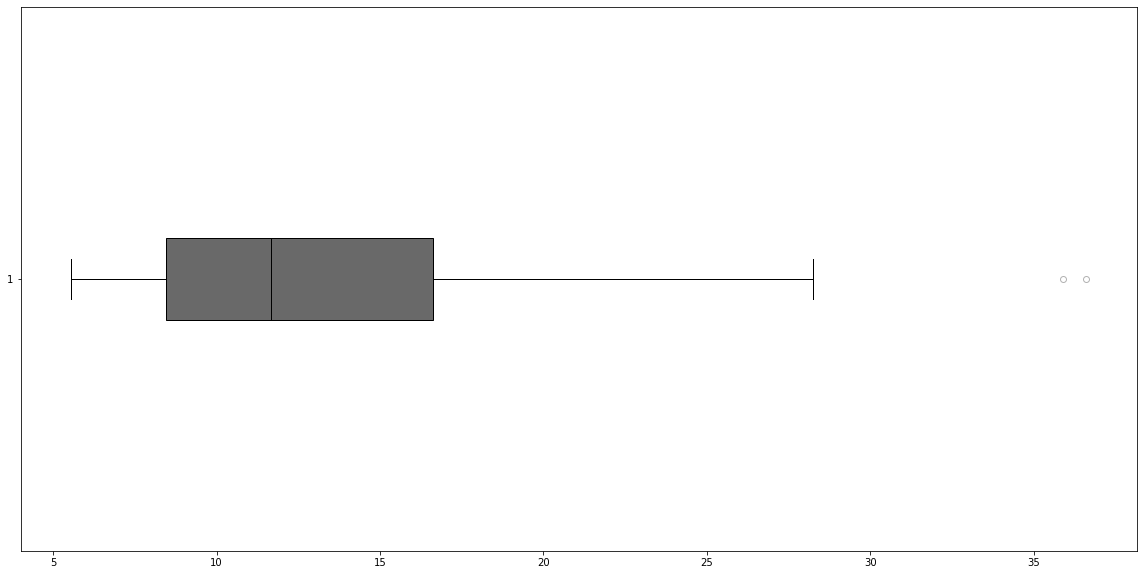

In [18]:
plt.figure(figsize=(20,10))
patch = plt.boxplot(combinedYieldsDF['so2'], vert=False, patch_artist=True)
style_boxplot(patch)
plt.show()

In [19]:
combinedYieldsDF[combinedYieldsDF['so2'] > 30]

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
24,1998-99,FARIDABAD,35.9,12.066667,164.467617,435.000000,435.000000,30124,70000,2.323729,128881,459000,3.561425
25,1999-00,FARIDABAD,36.6,11.033333,164.467617,403.666667,403.666667,28820,58000,2.012491,130923,545000,4.162752


**Remove Outliers**

> As the above two records are clearly outliers, we can remove them.

In [20]:
finalYieldsDF = combinedYieldsDF[combinedYieldsDF['so2'] <= 30]

### NO2

In [21]:
describe_numerical(combinedYieldsDF['no2'])

,no2
count,64.000000
mean,28.175477
std,9.691153
min,11.033333
25%,21.077343
50%,28.156074
75%,33.487500
max,60.762205
range,49.728871
iqr,12.410157


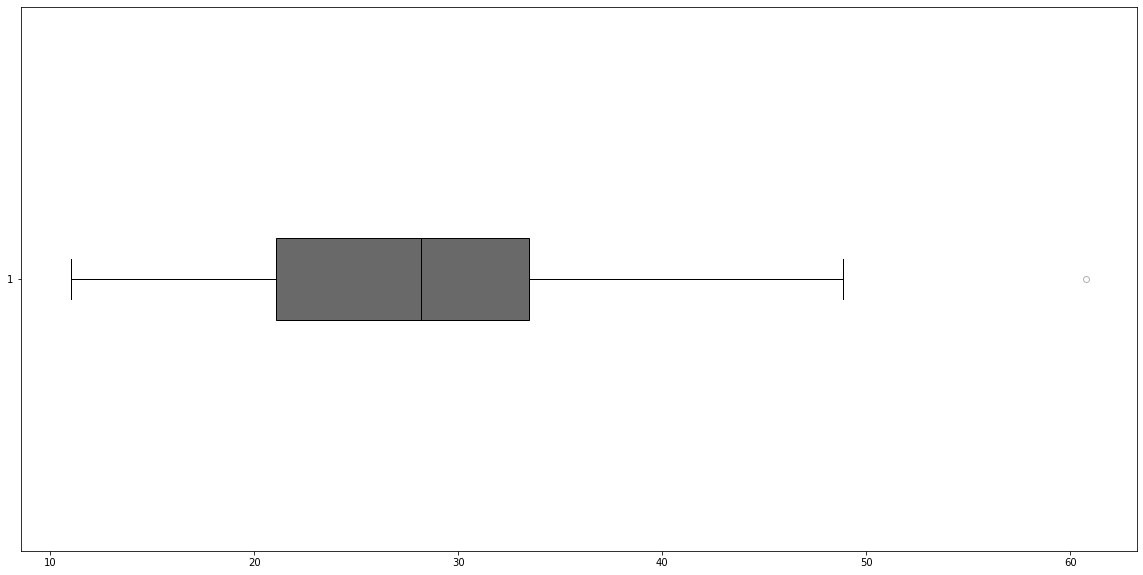

In [22]:
plt.figure(figsize=(20,10))
patch = plt.boxplot(combinedYieldsDF['no2'], vert=False, patch_artist=True)
style_boxplot(patch)
plt.show()

In [23]:
finalYieldsDF[finalYieldsDF['no2'] > 50]

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
23,2007-08,DELHI,8.458228,60.762205,223.590164,467.917323,467.917323,7419,20946,2.823292,17482,76222,4.360027


**Remove Outliers**

> As the above record is clearly outliers, we can remove them.

In [24]:
finalYieldsDF = finalYieldsDF[finalYieldsDF['no2'] <= 50]

### RSPM

In [25]:
describe_numerical(combinedYieldsDF['rspm'])

,rspm
count,64.000000
mean,166.841525
std,37.818323
min,87.398089
25%,157.239089
50%,175.716895
75%,198.152590
max,223.590164
range,136.192075
iqr,40.913501


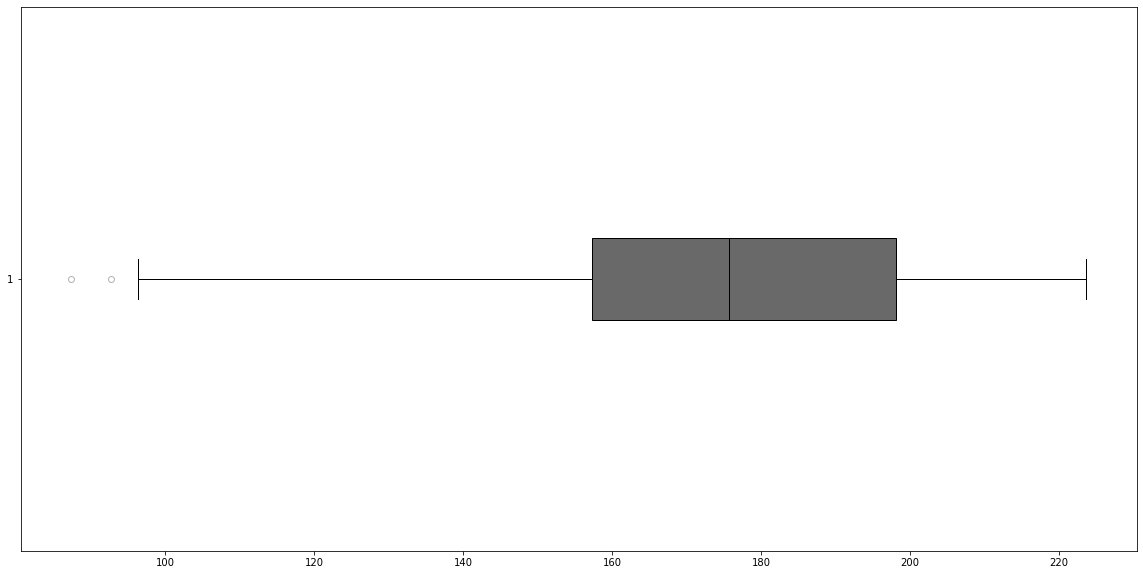

In [26]:
plt.figure(figsize=(20,10))
patch = plt.boxplot(combinedYieldsDF['rspm'], vert=False, patch_artist=True)
style_boxplot(patch)
plt.show()

In [27]:
finalYieldsDF[finalYieldsDF['rspm'] < 95]

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
12,2010-11,AHMEDABAD,14.872204,28.348243,87.398089,147.638456,147.638456,113500,310300,2.733921,230400,547600,2.376736
13,2011-12,AHMEDABAD,13.386139,26.207921,92.752475,94.250606,94.250606,133100,365600,2.746807,189800,473900,2.496839


**Remove Outliers**

> As the above two records are clearly outliers, we can remove them.

In [28]:
finalYieldsDF = finalYieldsDF[finalYieldsDF['rspm'] >= 95]

### SPM

In [29]:
describe_numerical(combinedYieldsDF['spm'])

,spm
count,64.000000
mean,338.097523
std,86.863115
min,94.250606
25%,270.812500
50%,338.899587
75%,404.602000
max,485.471774
range,391.221168
iqr,133.789500


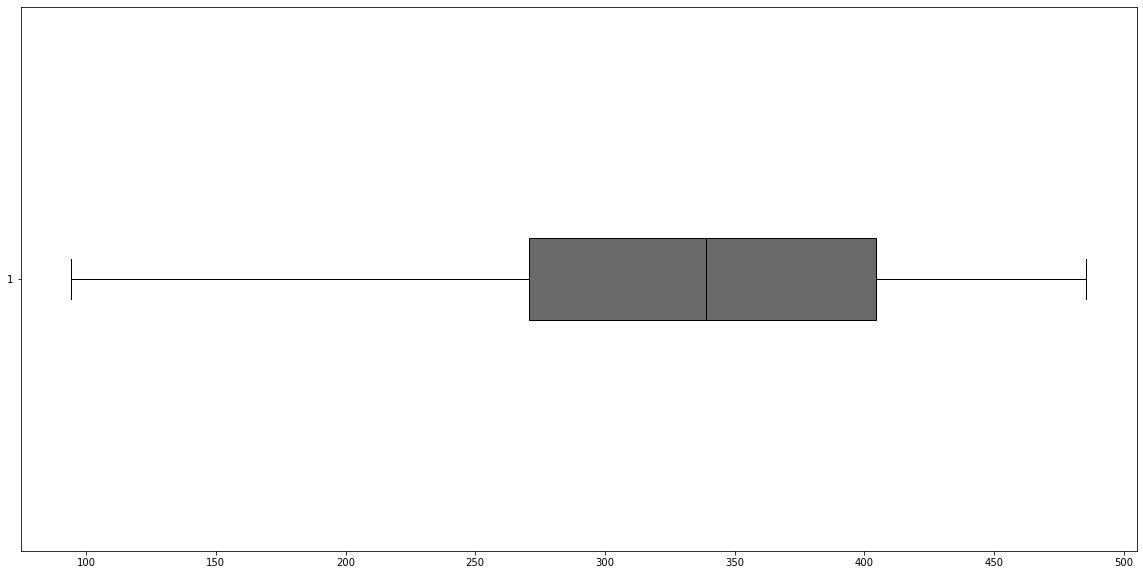

In [30]:
plt.figure(figsize=(20,10))
patch = plt.boxplot(combinedYieldsDF['spm'], vert=False, patch_artist=True)
style_boxplot(patch)
plt.show()

**Remove Outliers**

> No outliers to be removed for `SPM`

### AQI

In [31]:
describe_numerical(combinedYieldsDF['aqi'])

,aqi
count,64.000000
mean,338.097523
std,86.863115
min,94.250606
25%,270.812500
50%,338.899587
75%,404.602000
max,485.471774
range,391.221168
iqr,133.789500


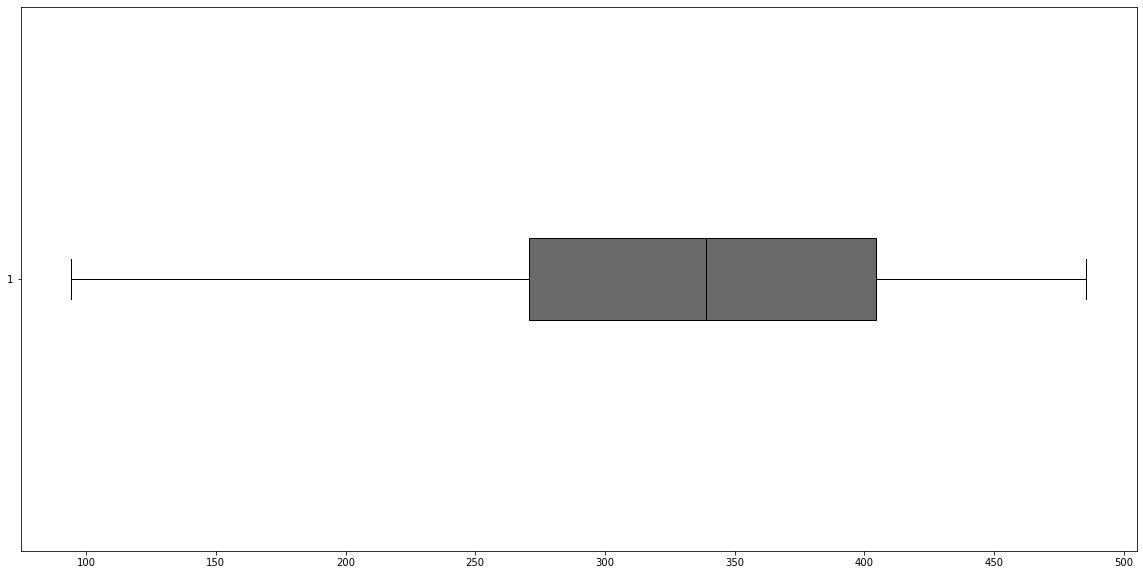

In [32]:
plt.figure(figsize=(20,10))
patch = plt.boxplot(combinedYieldsDF['aqi'], vert=False, patch_artist=True)
style_boxplot(patch)
plt.show()

**Remove Outliers**

> No outliers to be removed for `AQI`

### Rice Area, Rice Production, Rice Yield, Wheat Area, Wheat Production & Wheat Yield

**`Yield = Production/Area`** 

As `Yield` is the `Dependent Variable` and as Area & Production are not `Independent Variables`, there is no need for univariate EDA of the above features

## Pairwise-Variable EDA

While exploring pairwise EDA, we are trying to understand the mutual influence of variables within themselves.  In statistical parlance, this could be termed as *`influence of independent/predictor variable over dependent variable`*

We can use **`Pairwise Plots`** to find the correlation between dependent and independent variables.

For the bivariate combination of Numerical & Numerical (`so2, no2, rspm, spm, aqi & yield`) variables, we will use the **`Pearson's & Spearman's`** method to calculate the correlation coefficient.  
- All the coefficients range from -1 to +1

#### What is Correlation Coefficient?
 The correlation coefficient is a statistical measure of the strength of the relationship between the relative movements of two variables. The values range between -1.0 and 1.0. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

Corr(X,Y) = Cov(X,Y) / σXσY

|Correlation Coefficient for a Direct Relationship|Correlation Coefficient for a Indirect Relationship|Relationship Strength|
|-|-|-|
|0.0|0.0|**None/Trivial**|
|0.1|-0.1|**Weak/Small**|
|0.3|-0.3|**Moderate/Medium**|
|0.5|-0.5|**Strong/Large**|
|1.0|-1.0|**Perfect**|

### SO2 vs Yield

In [33]:
correlation(finalYieldsDF, 'so2', 'rice_yield')

,Correlation
"Pearson, 𝑟",-0.189921
"Spearman, 𝜌",-0.171128


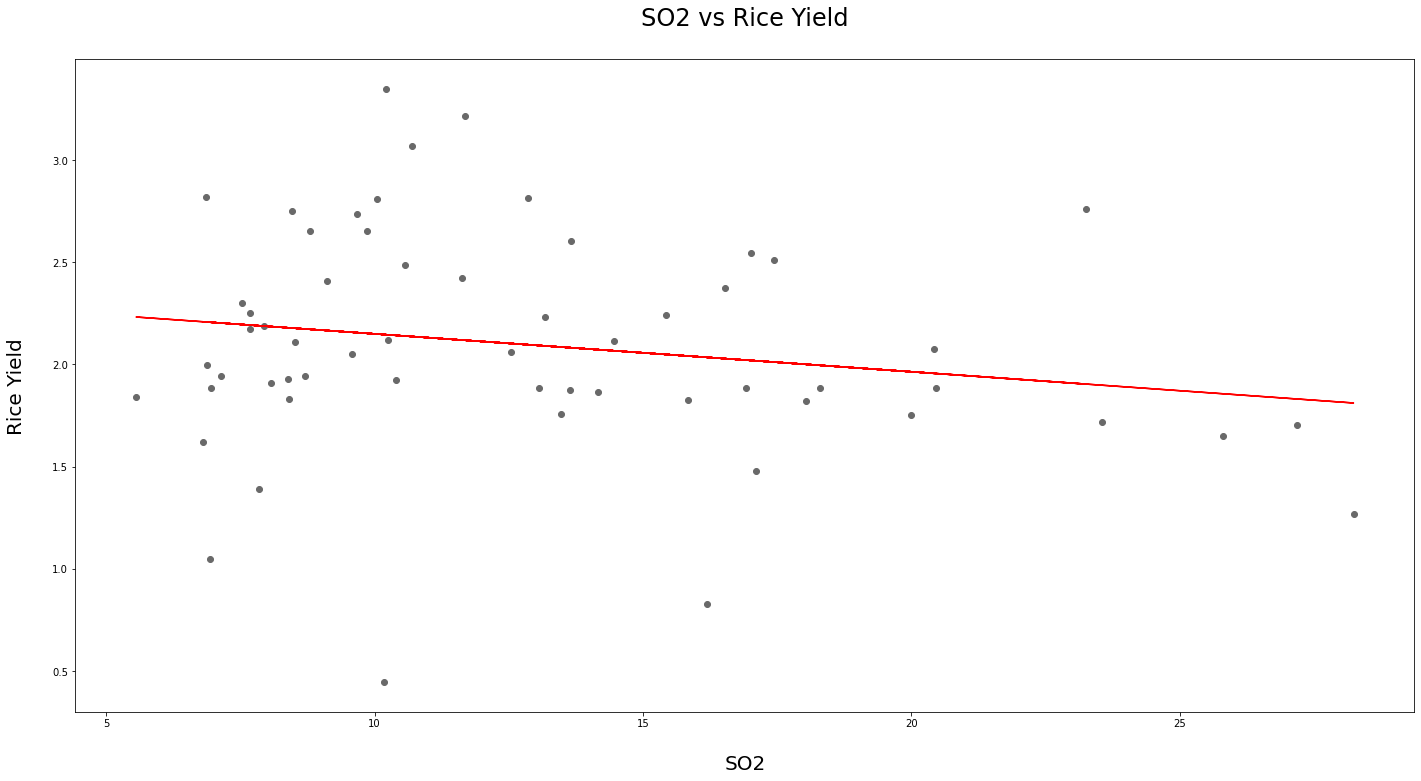

In [34]:
plt.figure(figsize=(24,12))
plt.xlabel('\nSO2', fontsize=20)
plt.ylabel('Rice Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['so2'],finalYieldsDF['rice_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['so2'],finalYieldsDF['rice_yield'], 1)
plt.plot(finalYieldsDF['so2'], m*finalYieldsDF['so2'] + b,color='Red')
plt.title("SO2 vs Rice Yield\n", fontsize=24)
plt.show()

In [35]:
correlation(finalYieldsDF, 'so2', 'wheat_yield')

,Correlation
"Pearson, 𝑟",-0.087216
"Spearman, 𝜌",-0.077031


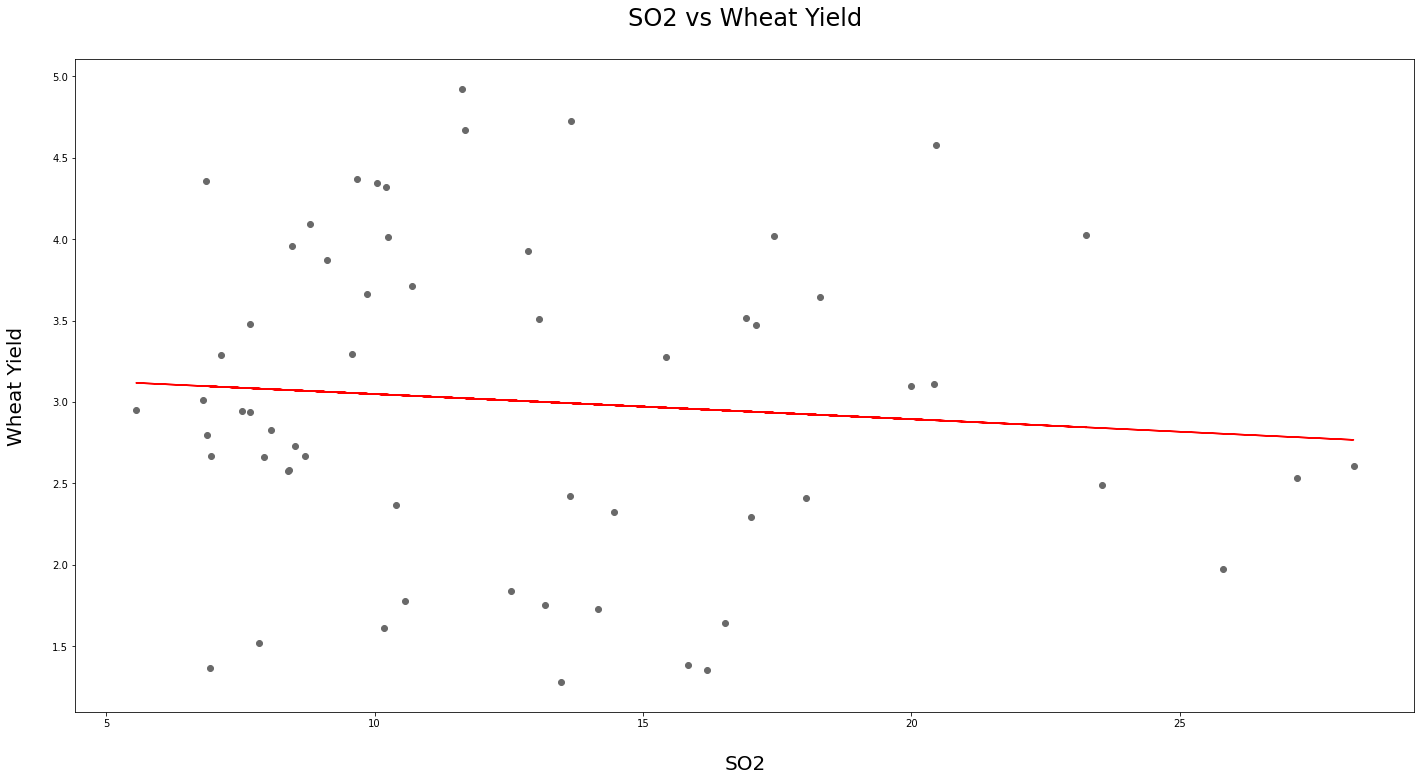

In [36]:
plt.figure(figsize=(24,12))
plt.xlabel('\nSO2', fontsize=20)
plt.ylabel('Wheat Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['so2'],finalYieldsDF['wheat_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['so2'],finalYieldsDF['wheat_yield'], 1)
plt.plot(finalYieldsDF['so2'], m*finalYieldsDF['so2'] + b,color='Red')
plt.title("SO2 vs Wheat Yield\n", fontsize=24)
plt.show()

**`SO2 vs Yield`** is **Moderately (-ve)** Correlated for **Rice** & **Weakly (-ve)** Correlated for **Wheat**

### NO2 vs Yield

In [37]:
correlation(finalYieldsDF, 'no2', 'rice_yield')

,Correlation
"Pearson, 𝑟",0.100672
"Spearman, 𝜌",0.021859


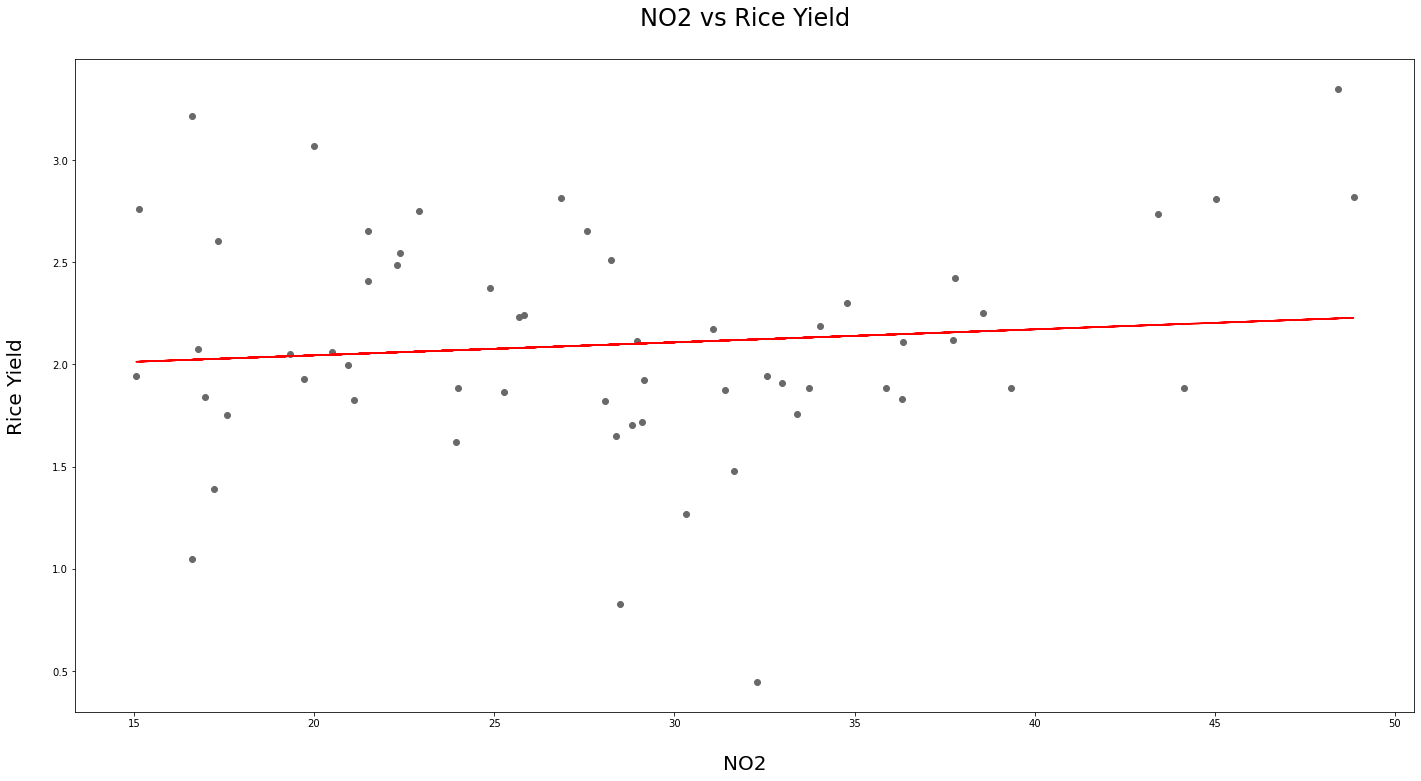

In [38]:
plt.figure(figsize=(24,12))
plt.xlabel('\nNO2', fontsize=20)
plt.ylabel('Rice Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['no2'],finalYieldsDF['rice_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['no2'],finalYieldsDF['rice_yield'], 1)
plt.plot(finalYieldsDF['no2'], m*finalYieldsDF['no2'] + b,color='Red')
plt.title("NO2 vs Rice Yield\n", fontsize=24)
plt.show()

In [39]:
correlation(finalYieldsDF, 'no2', 'wheat_yield')

,Correlation
"Pearson, 𝑟",0.289707
"Spearman, 𝜌",0.193805


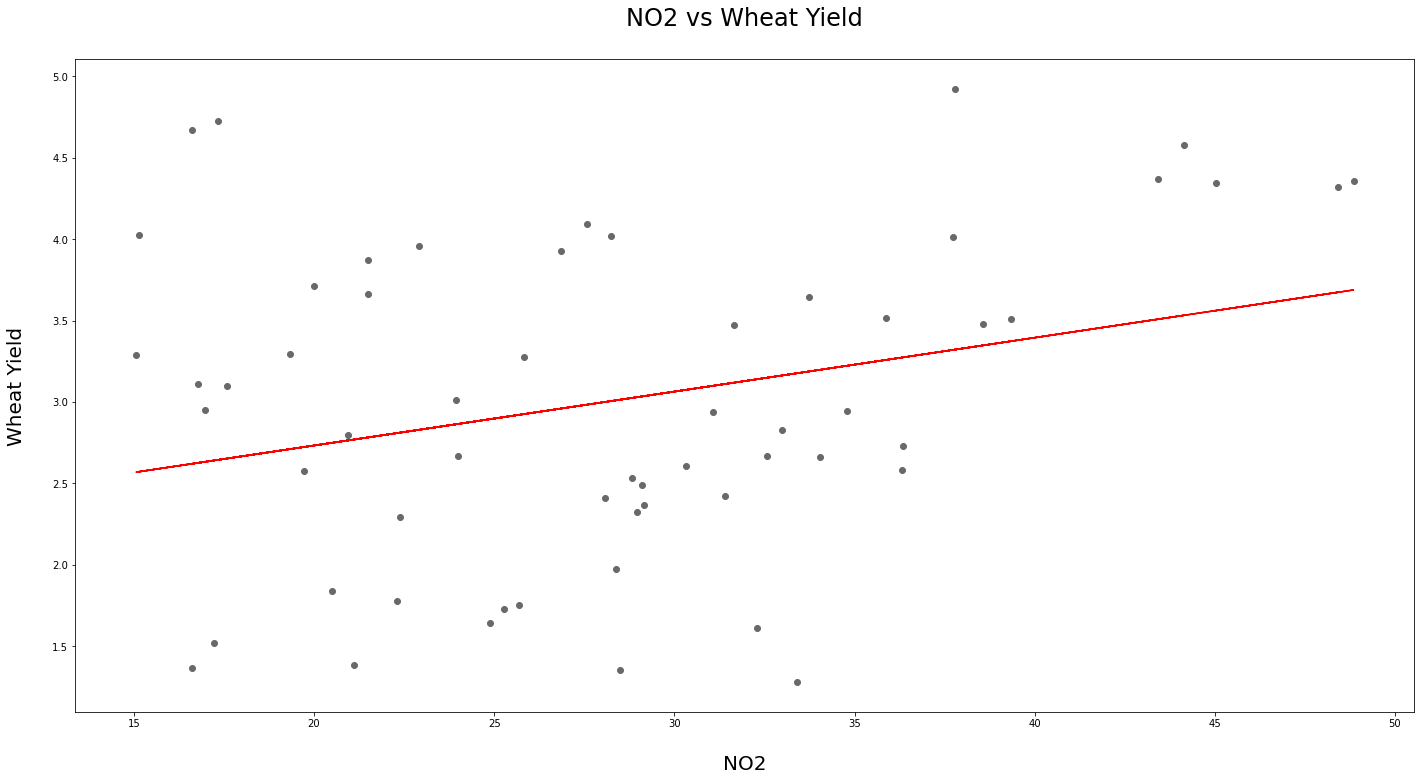

In [40]:
plt.figure(figsize=(24,12))
plt.xlabel('\nNO2', fontsize=20)
plt.ylabel('Wheat Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['no2'],finalYieldsDF['wheat_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['no2'],finalYieldsDF['wheat_yield'], 1)
plt.plot(finalYieldsDF['no2'], m*finalYieldsDF['no2'] + b,color='Red')
plt.title("NO2 vs Wheat Yield\n", fontsize=24)
plt.show()

**`NO2 vs Yield`** is **Weakly (+ve)** Correlated for **Rice** & **Moderately (+ve)** Correlated for **Wheat**

### RSPM vs Yield

In [41]:
correlation(finalYieldsDF, 'rspm', 'rice_yield')

,Correlation
"Pearson, 𝑟",0.078250
"Spearman, 𝜌",-0.129246


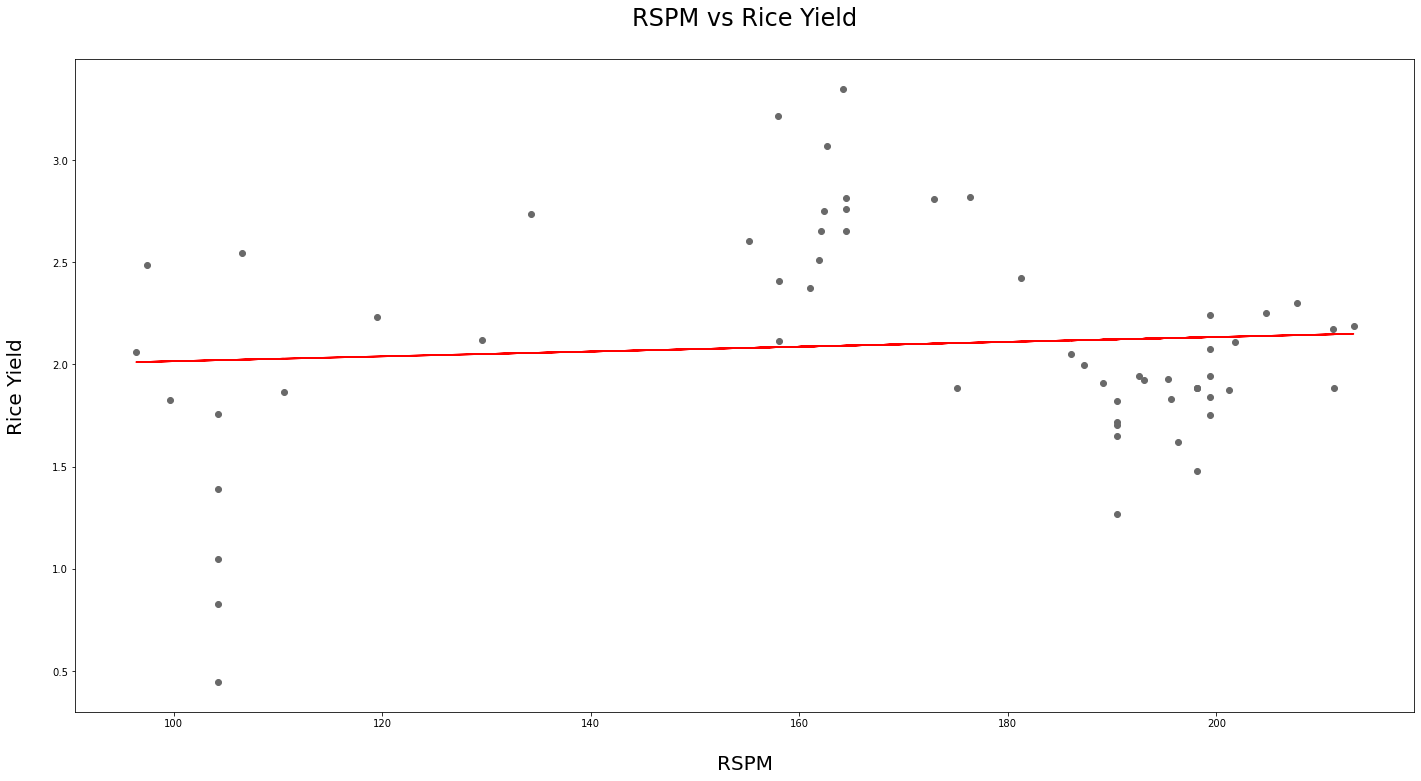

In [42]:
plt.figure(figsize=(24,12))
plt.xlabel('\nRSPM', fontsize=20)
plt.ylabel('Rice Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['rspm'],finalYieldsDF['rice_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['rspm'],finalYieldsDF['rice_yield'], 1)
plt.plot(finalYieldsDF['rspm'], m*finalYieldsDF['rspm'] + b,color='Red')
plt.title("RSPM vs Rice Yield\n", fontsize=24)
plt.show()

In [43]:
correlation(finalYieldsDF, 'rspm', 'wheat_yield')

,Correlation
"Pearson, 𝑟",0.384319
"Spearman, 𝜌",0.196735


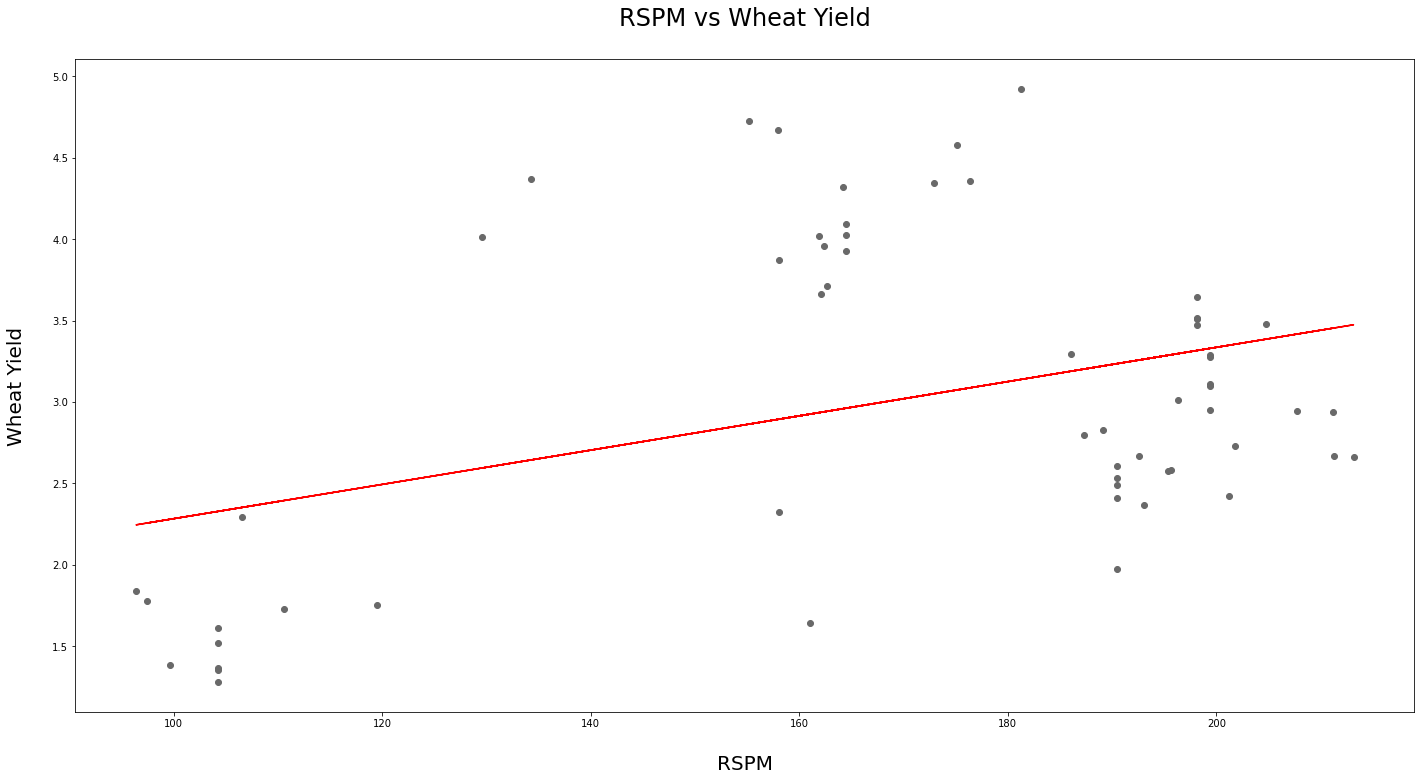

In [44]:
plt.figure(figsize=(24,12))
plt.xlabel('\nRSPM', fontsize=20)
plt.ylabel('Wheat Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['rspm'],finalYieldsDF['wheat_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['rspm'],finalYieldsDF['wheat_yield'], 1)
plt.plot(finalYieldsDF['rspm'], m*finalYieldsDF['rspm'] + b,color='Red')
plt.title("RSPM vs Wheat Yield\n", fontsize=24)
plt.show()

**`RSPM vs Yield`** is **Weakly (+ve)** Correlated for **Rice** & **Strongly (+ve)** Correlated for **Wheat**

### SPM vs Yield

In [45]:
correlation(finalYieldsDF, 'spm', 'rice_yield')

,Correlation
"Pearson, 𝑟",0.209234
"Spearman, 𝜌",0.229720


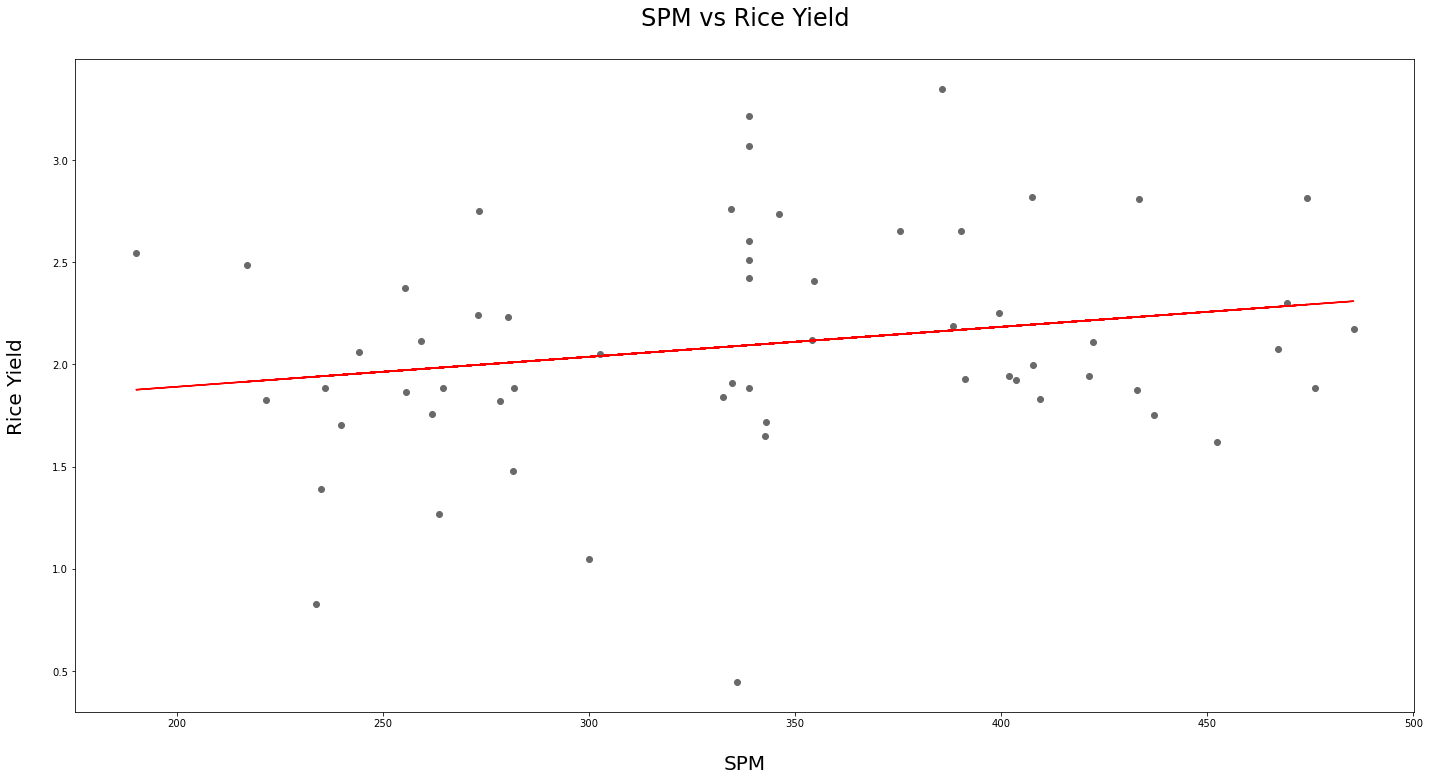

In [46]:
plt.figure(figsize=(24,12))
plt.xlabel('\nSPM', fontsize=20)
plt.ylabel('Rice Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['spm'],finalYieldsDF['rice_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['spm'],finalYieldsDF['rice_yield'], 1)
plt.plot(finalYieldsDF['spm'], m*finalYieldsDF['spm'] + b,color='Red')
plt.title("SPM vs Rice Yield\n", fontsize=24)
plt.show()

In [47]:
correlation(finalYieldsDF, 'spm', 'wheat_yield')

,Correlation
"Pearson, 𝑟",0.362878
"Spearman, 𝜌",0.382808


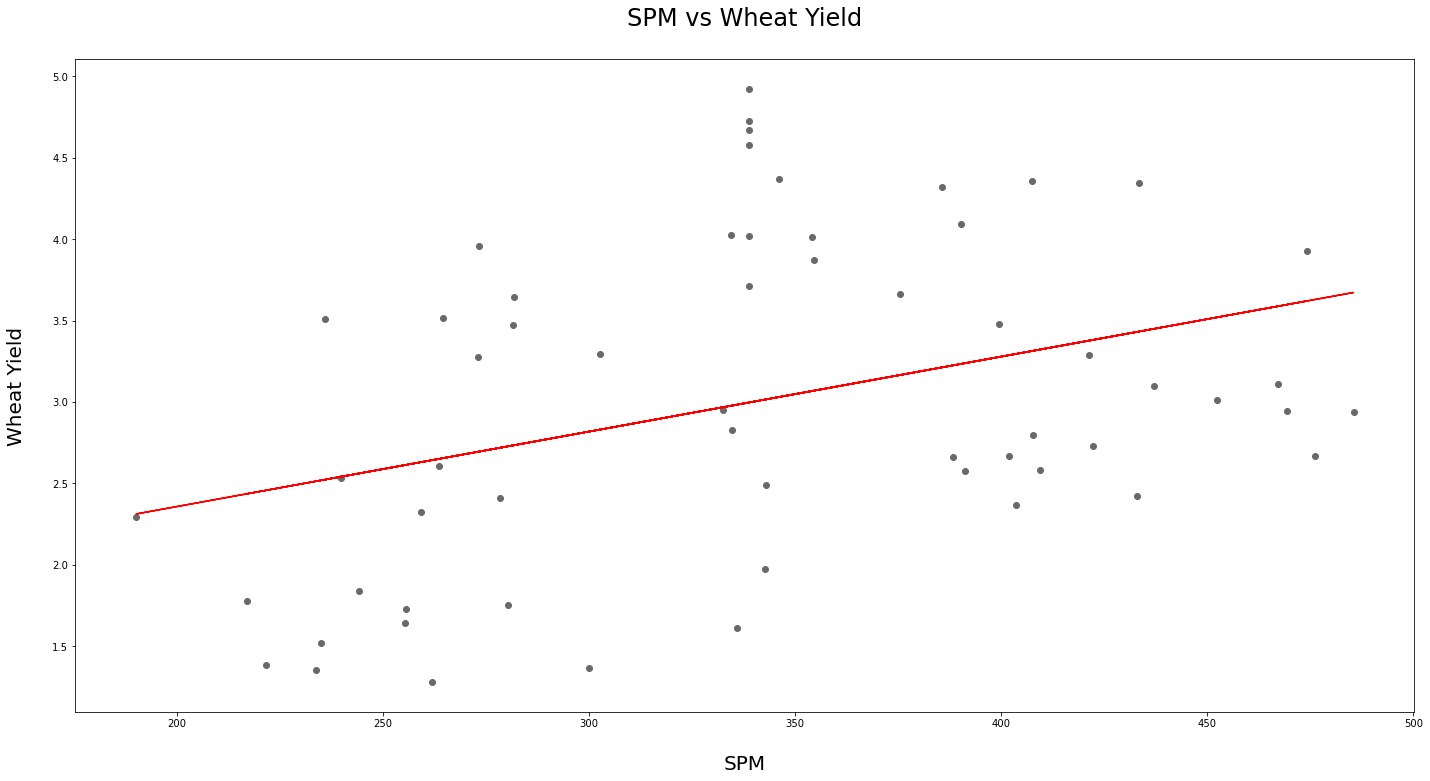

In [48]:
plt.figure(figsize=(24,12))
plt.xlabel('\nSPM', fontsize=20)
plt.ylabel('Wheat Yield\n', fontsize=20)
plt.scatter(finalYieldsDF['spm'],finalYieldsDF['wheat_yield'],color='DimGray')
m, b = np.polyfit(finalYieldsDF['spm'],finalYieldsDF['wheat_yield'], 1)
plt.plot(finalYieldsDF['spm'], m*finalYieldsDF['spm'] + b,color='Red')
plt.title("SPM vs Wheat Yield\n", fontsize=24)
plt.show()

**SPM vs Yield`** is **Moderately (+ve)** Correlated for **Rice** & **Strongly (+ve)** Correlated for **Wheat**

### Pairwise Variable EDA Summary

> As all the independent variables maintain Weak to Moderate correlation with the dependent variables.  As we have very few features (only 4), let us consider all the independent variables for model building.  In case when we have more features, we can drop those independent variables that are weakly correlated.  

## Model Building



## Candidate Models

### Candidate Model - XGBoost

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

- XGBoost is one of the implementations of Gradient Boosting concept, but what makes XGBoost unique is that it uses a more regularized model formalization to control over-fitting, which gives it better performance.

#### XGB Parameters

| Parameter | Description | Range |
| - | - | - |
| **nthread**| Number of parallel threads used to run XGBoost. When choosing it, please keep thread contention and hyperthreading in mind. | |
| **objective** | Learning task parameter. There are many, default is reg:squaredlogerror| |
| **learning_rate** | Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features,<br /> and learning_rate shrinks the feature weights to make the boosting process more conservative. | [0,1] |
| **max_depth** | Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in<br /> lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively<br /> consumes memory when training a deep tree. |  [0,∞] |
| **min_child_weight** | Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight<br /> less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to<br /> minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be. | [0,∞] |
| **silent** | Verbosity 0 (silent), 1 (warning), 2 (info), 3 (debug) | [0,3] |
| **subsample** | Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to<br /> growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. | (0,1] |
| **colsample_bytree** | Subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed. | (0, 1] |
| **n_estimators** | Number of estimators | [0,∞] |

#### Grid-Search

A model hyperparameter is a characteristic of a model that is external to the model and whose value cannot be estimated from data. The value of the hyperparameter has to be set before the learning process begins.  `Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.`  Grid search builds a model for every combination of hyperparameters specified and evaluates each model.

| Parameter | Description |
| - | - |
| **estimator** | This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed. |
| **param_grid** | Parameter of the model pass as a dictionary | 
| **cv** | Determines the cross-validation splitting strategy | 
| **scoring** | A single str (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions) to evaluate the predictions on the test set. |
| **refit** | Refit an estimator using the best found parameters on the whole dataset. |
| **n_jobs** | Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. |
| **verbose** | Controls the verbosity: the higher, the more messages. |


In [55]:
finalYieldsDF.head()

,date,district,so2,no2,rspm,spm,aqi,rice_area,rice_production,rice_yield,wheat_area,wheat_production,wheat_yield
0,1998-99,AHMEDABAD,7.850000,17.208333,104.200455,235.000000,235.000000,52200,72600,1.390805,91600,138900,1.516376
1,1999-00,AHMEDABAD,6.925000,16.608333,104.200455,300.000000,300.000000,75100,78900,1.050599,84000,114800,1.366667
2,2000-01,AHMEDABAD,10.175000,32.300000,104.200455,335.750000,335.750000,84100,37500,0.445898,48700,78500,1.611910
3,2001-02,AHMEDABAD,13.466667,33.408333,104.200455,261.750000,261.750000,82000,144300,1.759756,81000,103500,1.277778
4,2002-03,AHMEDABAD,16.187982,28.496361,104.200455,233.611749,233.611749,47500,39300,0.827368,79500,107400,1.350943


**Drop unwanted columns**

In [86]:
xgboostRiceYieldsDF = finalYieldsDF.drop(['date','aqi','rice_area','rice_production','wheat_area','wheat_production','wheat_yield'], axis='columns')
xgboostWheatYieldsDF = finalYieldsDF.drop(['date','aqi','rice_area','rice_production','rice_yield','wheat_area','wheat_production'], axis='columns')
xgboostRiceYieldsDF = pd.get_dummies(xgboostRiceYieldsDF, columns=['district'])
xgboostWheatYieldsDF = pd.get_dummies(xgboostWheatYieldsDF, columns=['district'])

In [87]:
xgboostRiceYieldsDF.head()

,so2,no2,rspm,spm,rice_yield,district_AHMEDABAD,district_DELHI,district_FARIDABAD,district_KANPUR,district_LUCKNOW
0,7.850000,17.208333,104.200455,235.000000,1.390805,1,0,0,0,0
1,6.925000,16.608333,104.200455,300.000000,1.050599,1,0,0,0,0
2,10.175000,32.300000,104.200455,335.750000,0.445898,1,0,0,0,0
3,13.466667,33.408333,104.200455,261.750000,1.759756,1,0,0,0,0
4,16.187982,28.496361,104.200455,233.611749,0.827368,1,0,0,0,0


In [88]:
xgboostWheatYieldsDF.head()

,so2,no2,rspm,spm,wheat_yield,district_AHMEDABAD,district_DELHI,district_FARIDABAD,district_KANPUR,district_LUCKNOW
0,7.850000,17.208333,104.200455,235.000000,1.516376,1,0,0,0,0
1,6.925000,16.608333,104.200455,300.000000,1.366667,1,0,0,0,0
2,10.175000,32.300000,104.200455,335.750000,1.611910,1,0,0,0,0
3,13.466667,33.408333,104.200455,261.750000,1.277778,1,0,0,0,0
4,16.187982,28.496361,104.200455,233.611749,1.350943,1,0,0,0,0


In [89]:
np.random.seed(1598743463)
X = xgboostRiceYieldsDF.loc[:, xgboostRiceYieldsDF.columns != 'rice_yield']
y = xgboostRiceYieldsDF['rice_yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print('Total: {0} - Train: {1} - Test: {2}'.format(len(X),len(X_train), len(X_test)))

Total: 59 - Train: 47 - Test: 12


In [90]:
xgbr = XGBRegressor()
xgbParms = { 
             'nthread':[10],
             'objective':['reg:squarederror'],
             'learning_rate': [0.001,0.01,0.03],
             'max_depth': [10],
             'min_child_weight': [4],
             'silent': [1],
             'subsample': [0.7],
             'colsample_bytree': [1.0],
             'n_estimators': [100, 300, 500]
            }
xgbrGridSearch = GridSearchCV(xgbr, xgbParms, cv = 10, scoring = 'neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

In [91]:
xgbrGridSearch.fit(X_train,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:   24.4s finished


[23:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [1.0],
         

In [92]:
print('Best Score: {0}\nBest Estimator: {1}'.format(xgbrGridSearch.best_score_,xgbrGridSearch.best_estimator_))

Best Score: -0.1737807318623962
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=10, nthread=10, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)


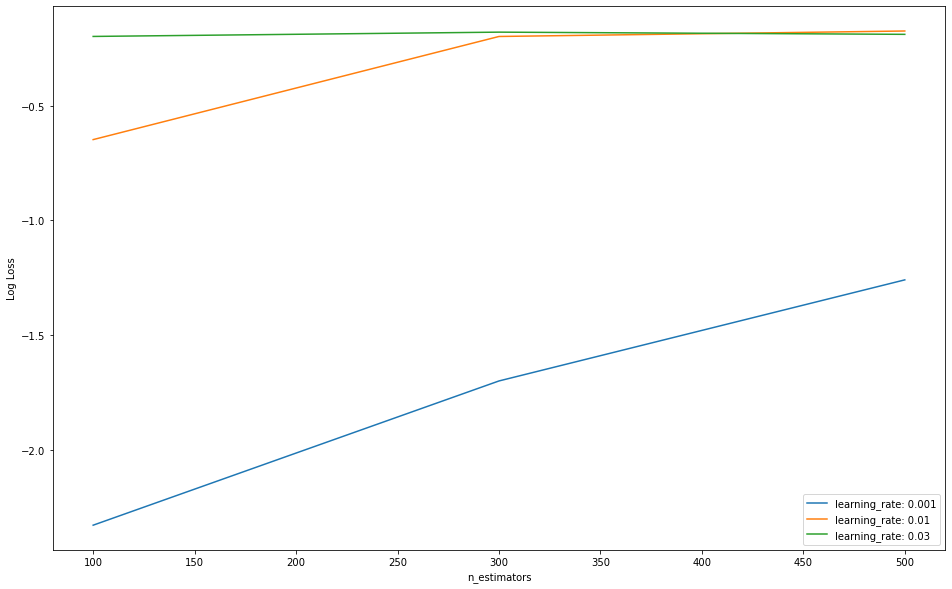

In [93]:
learning_rate = xgbParms['learning_rate']
n_estimators = xgbParms['n_estimators']
means = xgbrGridSearch.cv_results_['mean_test_score']
stds = xgbrGridSearch.cv_results_['std_test_score']
params = xgbrGridSearch.cv_results_['params']
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
plt.figure(figsize=(16,10))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

Above is a plot of each learning rate as a series showing log loss performance for varying range of trees.  In our case, 100,300 & 500.  - We can see that the expected general trend holds, where the performance (inverted log loss) improves as the number of trees is increased. 
- Performance is generally poor for the smaller learning rates, suggesting that a much larger number of trees may be required. 
- More the number of trees (n_estimators) and learning rates, the algorithm is computationally expensive. 

### Predict Rice Yield

In [94]:
XGB_best = xgbrGridSearch.best_estimator_
y_pred = XGB_best.predict(X_test)
explained_variance_score(y_test,y_pred)
mean_absolute_error(y_test,y_pred)
print('Mean Squared using XGBoost model = {0}'.format(mean_squared_error(y_test,y_pred,squared=True)))
print('R2 Score_XGBoost Regression = {0}'.format(metrics.r2_score(y_test,y_pred)))
print('Model Accuracy = {0}%'.format(round(metrics.r2_score(y_test,y_pred)*100,2)))

Mean Squared using XGBoost model = 0.12295882467623581
R2 Score_XGBoost Regression = 0.4349956081841089
Model Accuracy = 43.5%


#### Feature Importance

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

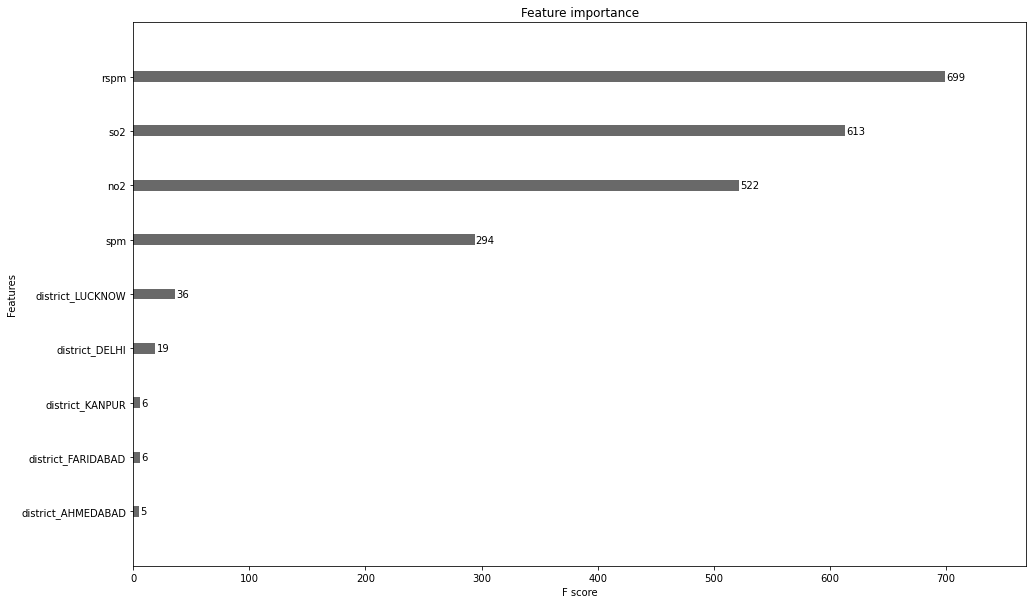

In [95]:
plt.rcParams["figure.figsize"] = (16,10)
plot_importance(booster=XGB_best, color="DimGray")
plt.grid(None)
plt.show()

For the `crop` prediction problem, using all variables as a base model and then brute forcing the difference between the base model and the base model + \<one_interaction_term\> for all possible interaction terms, i.e. $2^n-1$ models, the best accuracy we could get was 86%. *(For runtime purposes this analysis was done external to this Colab.)*

Using XGBoost along with Grid-Search-Tuned hyperparameters, we were able to get the highest level of accuracy of all candidate models at 97%, which is notably higher than our strongest efforts using Linear Regression and kNN Regression.

This level of accuracy might raise some concerns regarding overfitting. While this is normally warranted, the XGBoost algorithm uses regularization (L1 & L2) to avoid overfitting. Also, by restraining the learning rate we prevent the model from overly adapting to the training data as well.

As the XGBoost hyperparameters play a non-trivial role in speed, accuracy & overfitting, it is best to train the model using grid-search to narrow down to the optimal hyperparameters.  In particular, special attention must be paid to the following:

> - n-estimators - Number of Trees
> - learning_rate - Makes the model more robust by shrinking the weights on each step
> - max_depth - For Tree Pruning.  The maximum depth of a tree.
> - nthread - For Parallel Processing
> - subsample - Denotes the fraction of observations to be random samples for each tree.
> - eval_metric - The default values are rmse for regression and error for classification

For our case, the optimal values for each of the above hyperparameters were found to be the following:

* n-estimators: 500
* learning_rate: 0.03
* max_depth: 10
* nthread: 10
* subsample: 0.7
* eval_metric: "rmse"

In terms of the model itself, the importance of each variable tended to vary until the random seed was set, with the noted exception of `spm`, which has consistently been the most important predictor of all of the optimal XGBoost models that were searched out.

Lastly, XGBoost is a near-perfect *regularized boosting* algorithm with a combination of software, hardware & algorithmic optimization to yield superior results using fewer computing resources with minimal latency. 

In [96]:
np.random.seed(1598743463)
X = xgboostWheatYieldsDF.loc[:, xgboostWheatYieldsDF.columns != 'wheat_yield']
y = xgboostWheatYieldsDF['wheat_yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print('Total: {0} - Train: {1} - Test: {2}'.format(len(X),len(X_train), len(X_test)))

Total: 59 - Train: 47 - Test: 12


In [97]:
xgbr = XGBRegressor()
xgbParms = { 
             'nthread':[10],
             'objective':['reg:squarederror'],
             'learning_rate': [0.001,0.01,0.03],
             'max_depth': [10],
             'min_child_weight': [4],
             'silent': [1],
             'subsample': [0.7],
             'colsample_bytree': [1.0],
             'n_estimators': [100, 300, 500]
            }
xgbrGridSearch = GridSearchCV(xgbr, xgbParms, cv = 10, scoring = 'neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

In [98]:
xgbrGridSearch.fit(X_train,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:   25.1s finished


[23:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [1.0],
         

In [99]:
print('Best Score: {0}\nBest Estimator: {1}'.format(xgbrGridSearch.best_score_,xgbrGridSearch.best_estimator_))

Best Score: -0.2567507895768637
Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=10, nthread=10, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)


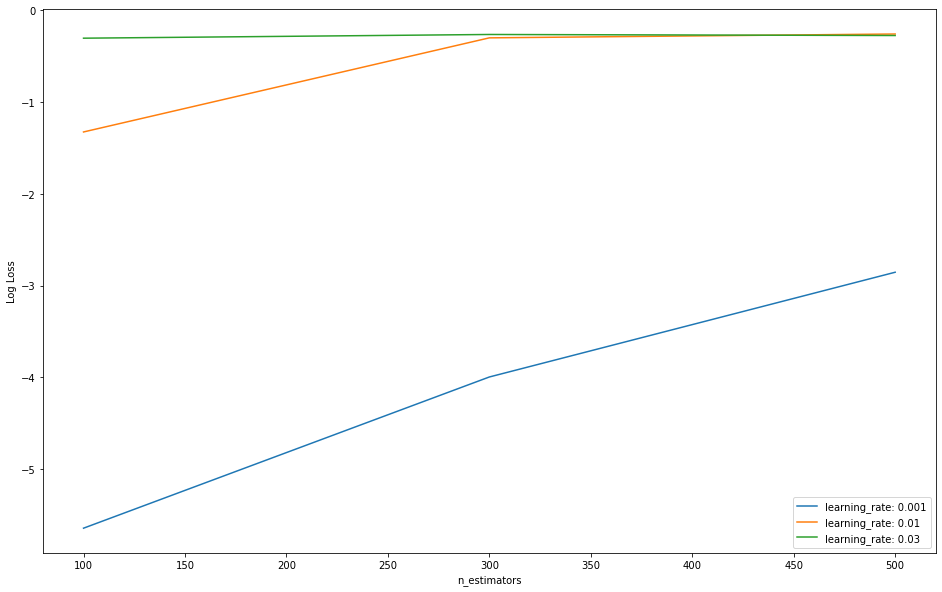

In [100]:
learning_rate = xgbParms['learning_rate']
n_estimators = xgbParms['n_estimators']
means = xgbrGridSearch.cv_results_['mean_test_score']
stds = xgbrGridSearch.cv_results_['std_test_score']
params = xgbrGridSearch.cv_results_['params']
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
plt.figure(figsize=(16,10))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

Above is a plot of each learning rate as a series showing log loss performance for varying range of trees.  In our case, 100,300 & 500.  - We can see that the expected general trend holds, where the performance (inverted log loss) improves as the number of trees is increased. 
- Performance is generally poor for the smaller learning rates, suggesting that a much larger number of trees may be required. 
- More the number of trees (n_estimators) and learning rates, the algorithm is computationally expensive. 

### Predict Wheat Yield

In [101]:
XGB_best = xgbrGridSearch.best_estimator_
y_pred = XGB_best.predict(X_test)
explained_variance_score(y_test,y_pred)
mean_absolute_error(y_test,y_pred)
print('Mean Squared using XGBoost model = {0}'.format(mean_squared_error(y_test,y_pred,squared=True)))
print('R2 Score_XGBoost Regression = {0}'.format(metrics.r2_score(y_test,y_pred)))
print('Model Accuracy = {0}%'.format(round(metrics.r2_score(y_test,y_pred)*100,2)))

Mean Squared using XGBoost model = 0.07833754153871364
R2 Score_XGBoost Regression = 0.903627216744935
Model Accuracy = 90.36%


#### Feature Importance

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

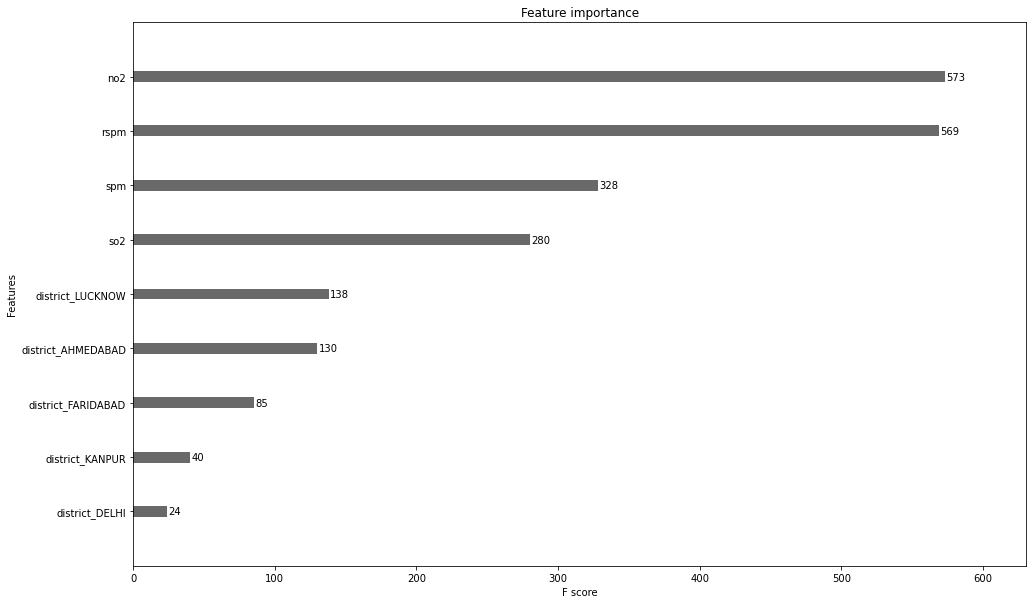

In [102]:
plt.rcParams["figure.figsize"] = (16,10)
plot_importance(booster=XGB_best, color="DimGray")
plt.grid(None)
plt.show()

For the `crop` prediction problem, using all variables as a base model and then brute forcing the difference between the base model and the base model + \<one_interaction_term\> for all possible interaction terms, i.e. $2^n-1$ models, the best accuracy we could get was 86%. *(For runtime purposes this analysis was done external to this Colab.)*

Using XGBoost along with Grid-Search-Tuned hyperparameters, we were able to get the highest level of accuracy of all candidate models at 97%, which is notably higher than our strongest efforts using Linear Regression and kNN Regression.

This level of accuracy might raise some concerns regarding overfitting. While this is normally warranted, the XGBoost algorithm uses regularization (L1 & L2) to avoid overfitting. Also, by restraining the learning rate we prevent the model from overly adapting to the training data as well.

As the XGBoost hyperparameters play a non-trivial role in speed, accuracy & overfitting, it is best to train the model using grid-search to narrow down to the optimal hyperparameters.  In particular, special attention must be paid to the following:

> - n-estimators - Number of Trees
> - learning_rate - Makes the model more robust by shrinking the weights on each step
> - max_depth - For Tree Pruning.  The maximum depth of a tree.
> - nthread - For Parallel Processing
> - subsample - Denotes the fraction of observations to be random samples for each tree.
> - eval_metric - The default values are rmse for regression and error for classification

For our case, the optimal values for each of the above hyperparameters were found to be the following:

* n-estimators: 500
* learning_rate: 0.03
* max_depth: 10
* nthread: 10
* subsample: 0.7
* eval_metric: "rmse"

In terms of the model itself, the importance of each variable tended to vary until the random seed was set, with the noted exception of `no2`, which has consistently been the most important predictor of all of the optimal XGBoost models that were searched out.

Lastly, XGBoost is a near-perfect *regularized boosting* algorithm with a combination of software, hardware & algorithmic optimization to yield superior results using fewer computing resources with minimal latency. 